In [1]:
import numpy as np
from sklearn.metrics import accuracy_score

import time

import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Dropout

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
from svm import *
from hog_class import *
from functions import *

In [4]:
cell_size = (8, 8)
block_size = (2, 2)
nbins = 9
threadsperblock = (32,32)
hog = HOG_CUDA_2(block_size, cell_size, nbins, 40,threadsperblock )

In [5]:
acc_SVM1 = []
acc_SVM2 = []
acc_CNN = []
time_SVM1 = []
time_SVM2 = []
time_CNN = []

In [6]:
n_test = [100, 200, 500, 1000, 1500, 2000,4000,6000]
link_cat = "./drive/MyDrive/LTSS/data2/Cat/**"
link_dog = "./drive/MyDrive/LTSS/data2/Dog/**"

In [7]:
model = Sequential()
model.add(Conv2D(filters = 64, kernel_size = (5,5), activation = "relu", input_shape = (128,128,3)))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 16, kernel_size = (5,5), activation = "relu"))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units = 256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(units = 1, activation = "sigmoid"))

model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        51232     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 29, 29, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 16)        1

In [8]:
for n in n_test:
    X_train, y_train, X_test, y_test = read_data(link_cat, link_dog, n_samples = n, image_size = (128, 128))
    
    print(n)
    print("Parallel SVM - linear")
    start = time.time()
    svm = SVM_Pa(kernel = 'linear')
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, hog, svm)
    end = time.time()
    time_SVM1.append(end-start)
    acc_SVM1.append(accuracy_score(pred, y_test))
    
    print("Parallel SVM - rbf")
    start = time.time()
    svm = SVM_Pa(kernel="rbf")
    big_fit(X_train, y_train, hog, svm)
    pred = big_predict(X_test, hog, svm)
    end = time.time()
    time_SVM2.append(end-start)
    acc_SVM2.append(accuracy_score(pred, y_test))
    
    print("CNN")
    y_train = np.array([0 if i == -1 else 1 for i in y_train])
    y_test = np.array([0 if i == -1 else 1 for i in y_test])
    if X_train.shape[0] < 400:
        start = time.time()
        model.fit(X_train, y_train, epochs = 20)
        pred = model.predict(X_test)
        end  = time.time()
        pred = pred.round(0).astype(int)
        time_CNN.append(end-start)
        acc_CNN.append(accuracy_score(pred, y_test))
    else:
        X_train,X_val,y_train,y_val = train_test_split(X_train, y_train, test_size=0.2, random_state = 42)
        start = time.time()
        model.fit(X_train, y_train,validation_data = (X_val,y_val), epochs = 20)
        pred = model.predict(X_test)
        pred = pred.round(0).astype(int)
        end = time.time()
        time_CNN.append(end-start)
        acc_CNN.append(accuracy_score(pred, y_test))
    
    

100
Parallel SVM - linear


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 16 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to

Parallel SVM - rbf


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 9 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 3 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CNN
Epoch 1/20
3/3 [==============================] - 12s 125ms/step - loss: 57.4958 - accuracy: 0.5714
Epoch 2/20
3/3 [==============================] - 0s 18ms/step - loss: 24.6773 - accuracy: 0.5143
Epoch 3/20
3/3 [==============================] - 0s 17ms/step - loss: 3.9697 - accuracy: 0.5429
Epoch 4/20
3/3 [==============================] - 0s 17ms/step - loss: 0.9563 - accuracy: 0.6286
Epoch 5/20
3/3 [==============================] - 0s 17ms/step - loss: 0.7229 - accuracy: 0.5571
Epoch 6/20
3/3 [==============================] - 0s 17ms/step - loss: 0.9210 - accuracy: 0.6286
Epoch 7/20
3/3 [==============================] - 0s 17ms/step - loss: 0.8338 - accuracy: 0.5714
Epoch 8/20
3/3 [==============================] - 0s 17ms/step - loss: 0.9568 - accuracy: 0.4429
Epoch 9/20
3/3 [==============================] - 0s 18ms/step - loss: 1.6588 - accuracy: 0.5000
Epoch 10/20
3/3 [==============================] - 0s 18ms/step - loss: 0.7409 - accuracy: 0.5429
Epoch 11/20
3/3 [====

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 5 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM - rbf


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 25 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CNN
Epoch 1/20
3/5 [=================>............] - ETA: 0s - loss: 1.0893 - accuracy: 0.5312

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


5/5 [==============================] - 1s 123ms/step - loss: 1.3451 - accuracy: 0.5214
Epoch 2/20
5/5 [==============================] - 0s 23ms/step - loss: 0.7010 - accuracy: 0.5143
Epoch 3/20
5/5 [==============================] - 0s 22ms/step - loss: 0.7161 - accuracy: 0.5500
Epoch 4/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6663 - accuracy: 0.5714
Epoch 5/20
5/5 [==============================] - 0s 25ms/step - loss: 0.6907 - accuracy: 0.5500
Epoch 6/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6893 - accuracy: 0.6000
Epoch 7/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6716 - accuracy: 0.5571
Epoch 8/20
5/5 [==============================] - 0s 22ms/step - loss: 0.6673 - accuracy: 0.5786
Epoch 9/20
5/5 [==============================] - 0s 23ms/step - loss: 0.6557 - accuracy: 0.5643
Epoch 10/20
5/5 [==============================] - 0s 22ms/step - loss: 2.7089 - accuracy: 0.5571
Epoch 11/20
5/5 [======================

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


500
Parallel SVM - linear


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 121 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 55 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM - rbf


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 121 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


CNN
Epoch 1/20
 1/11 [=>............................] - ETA: 0s - loss: 0.6891 - accuracy: 0.5938

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 55 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


11/11 [==============================] - 1s 62ms/step - loss: 0.7536 - accuracy: 0.5429
Epoch 2/20
11/11 [==============================] - 0s 25ms/step - loss: 0.7198 - accuracy: 0.5314
Epoch 3/20
11/11 [==============================] - 0s 25ms/step - loss: 0.6982 - accuracy: 0.5314
Epoch 4/20
11/11 [==============================] - 0s 25ms/step - loss: 0.6943 - accuracy: 0.5200
Epoch 5/20
11/11 [==============================] - 0s 25ms/step - loss: 0.6902 - accuracy: 0.5200
Epoch 6/20
11/11 [==============================] - 0s 25ms/step - loss: 0.8343 - accuracy: 0.5229
Epoch 7/20
11/11 [==============================] - 0s 25ms/step - loss: 0.7001 - accuracy: 0.5143
Epoch 8/20
11/11 [==============================] - 0s 24ms/step - loss: 0.7003 - accuracy: 0.5114
Epoch 9/20
11/11 [==============================] - 0s 24ms/step - loss: 0.9301 - accuracy: 0.5314
Epoch 10/20
11/11 [==============================] - 0s 26ms/step - loss: 0.6918 - accuracy: 0.5200
Epoch 11/20
11/11 [=

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1000
Parallel SVM - linear


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 22 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM - rbf
CNN
Epoch 1/20
18/18 [==============================] - 1s 63ms/step - loss: 0.7428 - accuracy: 0.5250 - val_loss: 0.6843 - val_accuracy: 0.5786
Epoch 2/20
18/18 [==============================] - 0s 26ms/step - loss: 0.7702 - accuracy: 0.5500 - val_loss: 0.6913 - val_accuracy: 0.5429
Epoch 3/20
18/18 [==============================] - 0s 28ms/step - loss: 0.6842 - accuracy: 0.5071 - val_loss: 0.7199 - val_accuracy: 0.6071
Epoch 4/20
18/18 [==============================] - 0s 26ms/step - loss: 0.7216 - accuracy: 0.5250 - val_loss: 0.6919 - val_accuracy: 0.5429
Epoch 5/20
18/18 [==============================] - 0s 26ms/step - loss: 0.6852 - accuracy: 0.5143 - val_loss: 0.6896 - val_accuracy: 0.5571
Epoch 6/20
18/18 [==============================] - 1s 28ms/step - loss: 0.6895 - accuracy: 0.5321 - val_loss: 0.6894 - val_accuracy: 0.5500
Epoch 7/20
18/18 [==============================] - 0s 28ms/step - loss: 0.6802 - accuracy: 0.5375 - val_loss: 0.6944 - val_accurac

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1500
Parallel SVM - linear


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 33 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM - rbf
CNN
Epoch 1/20
27/27 [==============================] - 1s 45ms/step - loss: 0.6999 - accuracy: 0.5042 - val_loss: 0.6885 - val_accuracy: 0.4905
Epoch 2/20
27/27 [==============================] - 1s 29ms/step - loss: 0.6863 - accuracy: 0.5089 - val_loss: 0.6874 - val_accuracy: 0.4905
Epoch 3/20
27/27 [==============================] - 1s 28ms/step - loss: 0.6972 - accuracy: 0.5173 - val_loss: 0.7382 - val_accuracy: 0.5000
Epoch 4/20
27/27 [==============================] - 1s 28ms/step - loss: 0.6930 - accuracy: 0.5352 - val_loss: 0.6718 - val_accuracy: 0.5143
Epoch 5/20
27/27 [==============================] - 1s 28ms/step - loss: 0.7091 - accuracy: 0.5340 - val_loss: 0.6902 - val_accuracy: 0.4952
Epoch 6/20
27/27 [==============================] - 1s 27ms/step - loss: 0.6820 - accuracy: 0.5244 - val_loss: 0.6674 - val_accuracy: 0.5143
Epoch 7/20
27/27 [==============================] - 1s 26ms/step - loss: 0.7160 - accuracy: 0.5399 - val_loss: 0.6927 - val_accurac

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


2000
Parallel SVM - linear


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 44 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM - rbf
CNN
Epoch 1/20
35/35 [==============================] - 1s 35ms/step - loss: 0.7268 - accuracy: 0.5125 - val_loss: 0.6864 - val_accuracy: 0.5214
Epoch 2/20
35/35 [==============================] - 1s 27ms/step - loss: 0.6950 - accuracy: 0.5116 - val_loss: 0.6904 - val_accuracy: 0.5143
Epoch 3/20
35/35 [==============================] - 1s 26ms/step - loss: 0.6946 - accuracy: 0.4893 - val_loss: 0.6906 - val_accuracy: 0.5143
Epoch 4/20
35/35 [==============================] - 1s 26ms/step - loss: 0.6932 - accuracy: 0.5081 - val_loss: 0.6866 - val_accuracy: 0.5250
Epoch 5/20
35/35 [==============================] - 1s 28ms/step - loss: 0.6966 - accuracy: 0.4982 - val_loss: 0.6879 - val_accuracy: 0.5214
Epoch 6/20
35/35 [==============================] - 1s 29ms/step - loss: 0.6912 - accuracy: 0.5009 - val_loss: 0.6923 - val_accuracy: 0.5179
Epoch 7/20
35/35 [==============================] - 1s 28ms/step - loss: 0.6924 - accuracy: 0.4875 - val_loss: 0.6912 - val_accurac

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


4000
Parallel SVM - linear


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 88 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Parallel SVM - rbf
CNN
Epoch 1/20
70/70 [==============================] - 2s 26ms/step - loss: 0.7006 - accuracy: 0.5018 - val_loss: 0.6917 - val_accuracy: 0.5107
Epoch 2/20
70/70 [==============================] - 2s 25ms/step - loss: 0.7102 - accuracy: 0.5022 - val_loss: 0.6918 - val_accuracy: 0.5107
Epoch 3/20
70/70 [==============================] - 2s 26ms/step - loss: 0.7066 - accuracy: 0.4839 - val_loss: 0.6838 - val_accuracy: 0.5232
Epoch 4/20
70/70 [==============================] - 2s 26ms/step - loss: 0.7127 - accuracy: 0.5031 - val_loss: 0.6917 - val_accuracy: 0.5125
Epoch 5/20
70/70 [==============================] - 2s 27ms/step - loss: 0.7089 - accuracy: 0.5031 - val_loss: 0.6874 - val_accuracy: 0.5179
Epoch 6/20
70/70 [==============================] - 2s 29ms/step - loss: 0.6864 - accuracy: 0.5107 - val_loss: 0.6902 - val_accuracy: 0.5125
Epoch 7/20
70/70 [==============================] - 2s 26ms/step - loss: 0.6951 - accuracy: 0.5147 - val_loss: 0.6889 - val_accurac

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:819: UserWarning: Truncated File Read
  warnings.warn(str(msg))


6000
Parallel SVM - linear
Parallel SVM - rbf
CNN
Epoch 1/20
105/105 [==============================] - 3s 30ms/step - loss: 0.7085 - accuracy: 0.5051 - val_loss: 0.6925 - val_accuracy: 0.5131
Epoch 2/20
105/105 [==============================] - 3s 27ms/step - loss: 0.6917 - accuracy: 0.5039 - val_loss: 0.6937 - val_accuracy: 0.5250
Epoch 3/20
105/105 [==============================] - 3s 26ms/step - loss: 0.6998 - accuracy: 0.5003 - val_loss: 0.6922 - val_accuracy: 0.5202
Epoch 4/20
105/105 [==============================] - 3s 28ms/step - loss: 0.7144 - accuracy: 0.5208 - val_loss: 0.6906 - val_accuracy: 0.5155
Epoch 5/20
105/105 [==============================] - 3s 26ms/step - loss: 0.6921 - accuracy: 0.5176 - val_loss: 0.6915 - val_accuracy: 0.5143
Epoch 6/20
105/105 [==============================] - 3s 28ms/step - loss: 0.6976 - accuracy: 0.5173 - val_loss: 0.6906 - val_accuracy: 0.5167
Epoch 7/20
105/105 [==============================] - 3s 26ms/step - loss: 0.7069 - accuracy

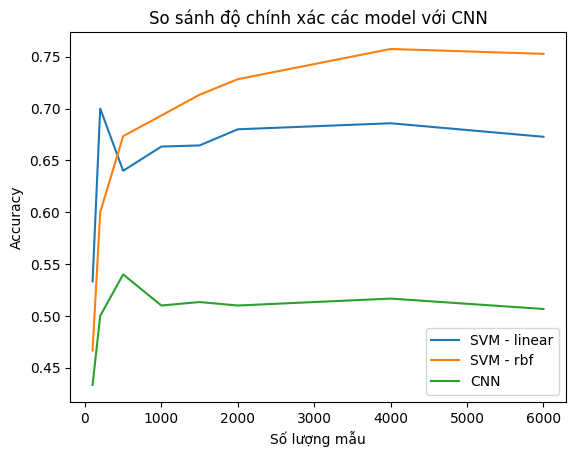

In [9]:
plt.plot(n_test, acc_SVM1 , label = 'SVM - linear')
plt.plot(n_test, acc_SVM2, label = 'SVM - rbf')
plt.plot(n_test, acc_CNN, label = 'CNN')
plt.xlabel("Số lượng mẫu")
plt.ylabel("Accuracy")
plt.title("So sánh độ chính xác các model với CNN")
plt.legend()
plt.show()

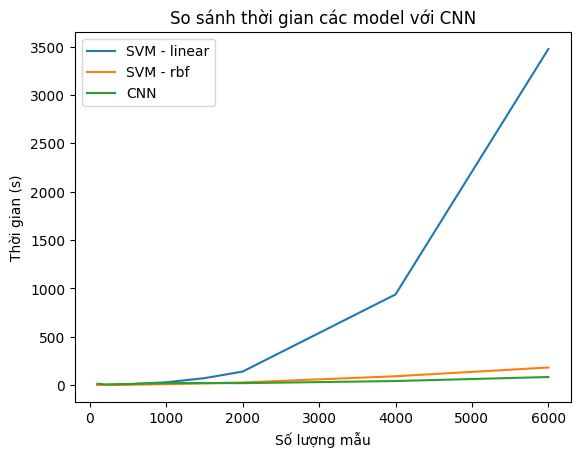

In [31]:
plt.plot(n_test, time_SVM1, label = 'SVM - linear')
plt.plot(n_test, time_SVM2, label = 'SVM - rbf')
plt.plot(n_test, time_CNN, label = 'CNN')
plt.xlabel("Số lượng mẫu")
plt.ylabel("Thời gian (s)")
plt.title("So sánh thời gian các model với CNN")
plt.legend()
plt.show()

In [15]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Nhận xét:

- Ta thấy SVM + HOG cho ra độ chính xác cao hơn hẳn CNN tại mọi số mẫu khác nhau.
- Thuật toán SVM với kernel RBF có xu hướng cho độ chính xác tăng dần khi số lượng dữ liệu tăng

    Trong khi kernel linear có dấu hiệu chững lại và hơi giảm xuống, kể cả vậy nó vẫn cao hơn nhiều so với CNN
- CNN cho độ chính xác trung bình trong khoảng 0.51 0.52. Tuy nhiên dữ liệu test là cân bằng (50-50 giữa 2 lớp) nên việc ra độ chính xác 0.51 là vô cùng thấp.
- CNN của tensorflow chạy trên GPU cho tốc độ nhỉnh hơn RBF 1 tí ở khoảng > 2000 mẫu. (lần báo cáo trước nhóm chạy CNN trên CPU)
- Số lượng mẫu càng lớn thì kernel linear càng khó hội tụ nên thời gian chạy lâu hơn.